# Stochastic Gradient Descent(SGD)

## Load Dataset from sklearn

In [7]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

In [5]:
df = pd.DataFrame(california.data, columns = california.feature_names)
df['Target'] = california.target 
df.tail() 

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [9]:
df.shape

(20640, 9)

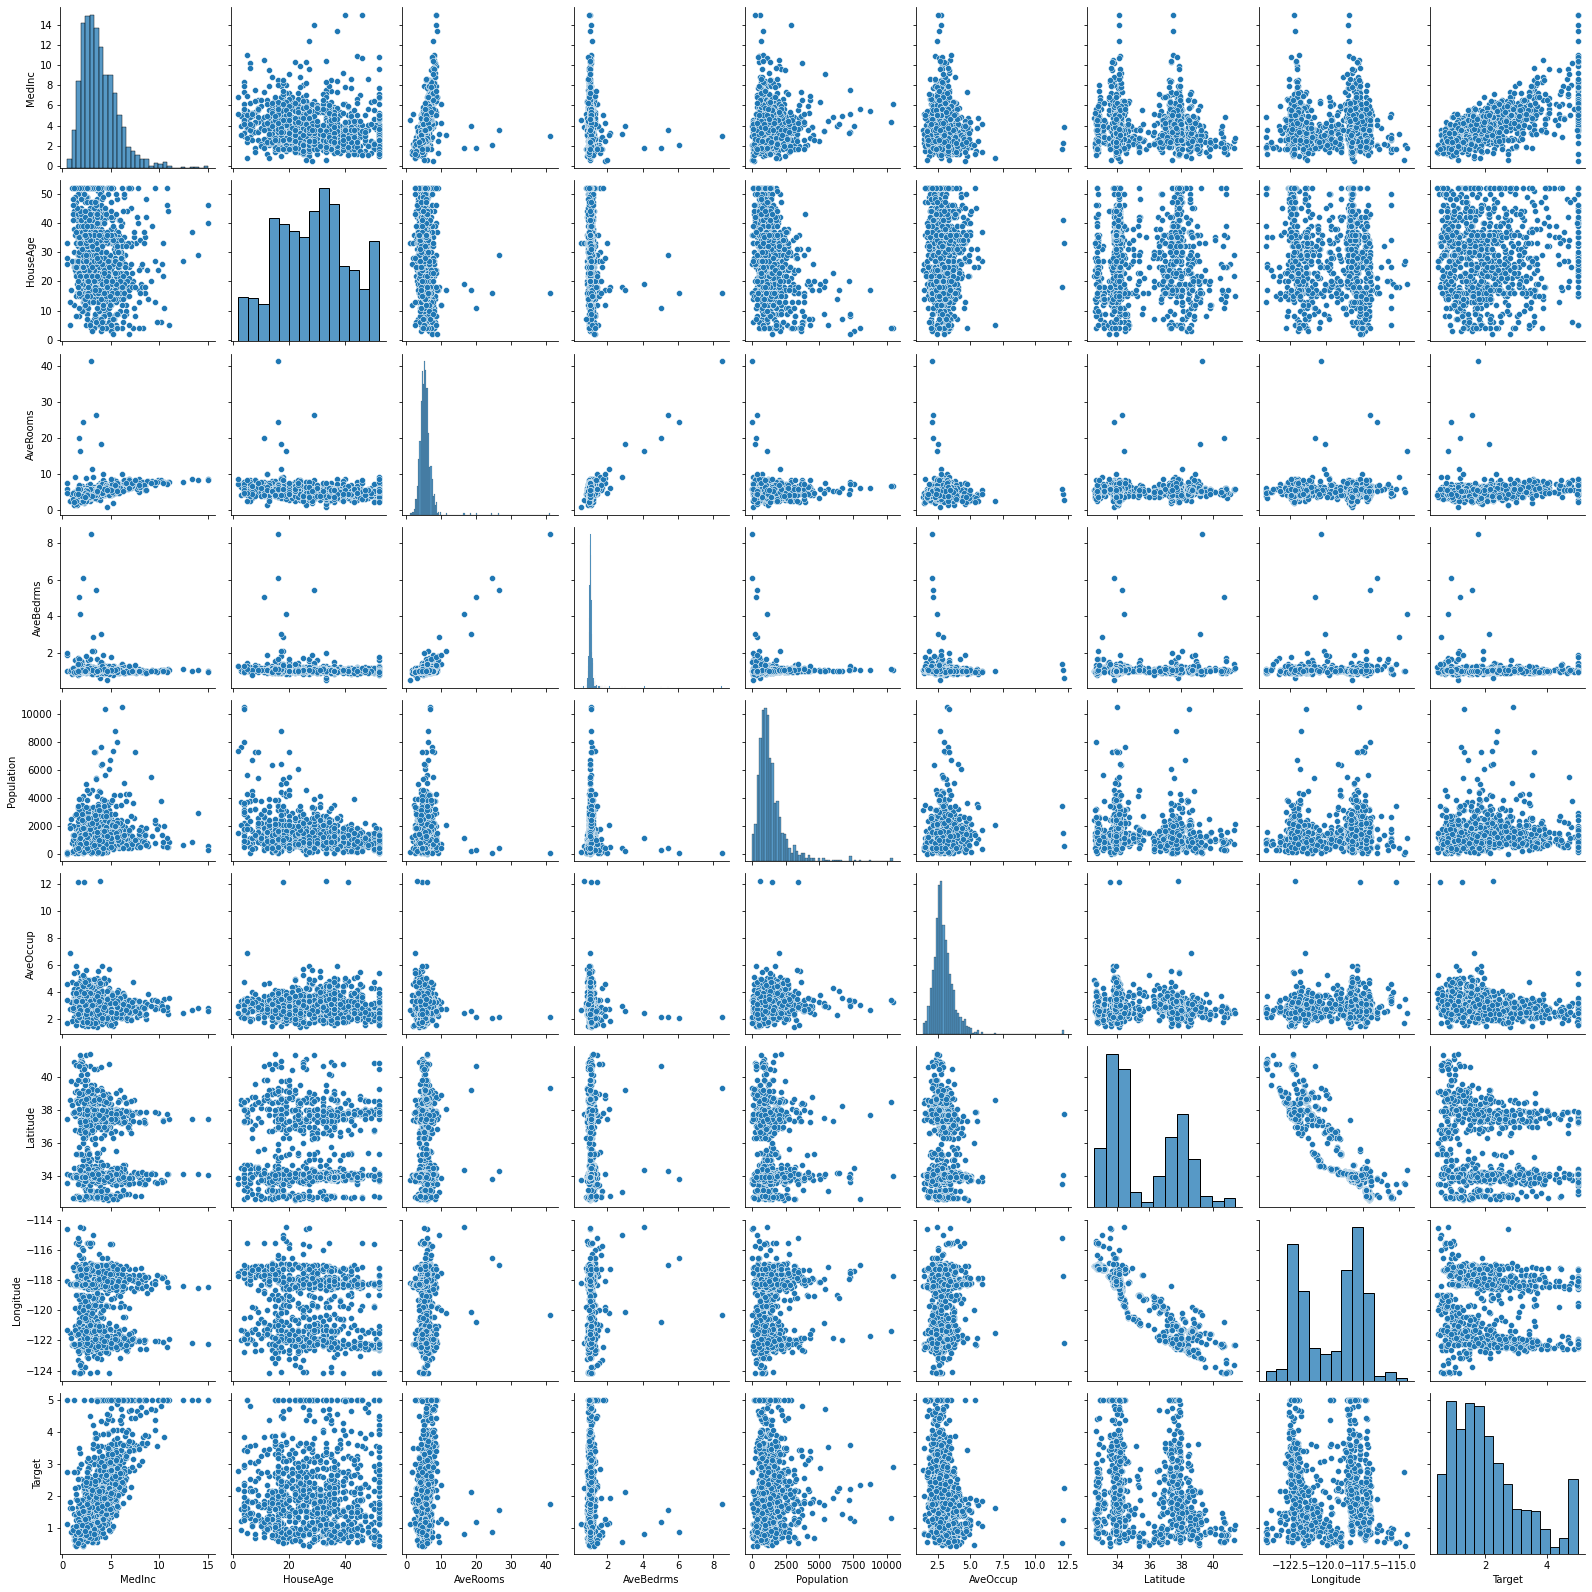

In [8]:
sns.pairplot(df.sample(1000))
plt.show()

값의 범위들이 다르기 때문에 scaling 

In [10]:
scaler = StandardScaler()
df.values[:, :-1] = scaler.fit_transform(df.values[:,:-1])

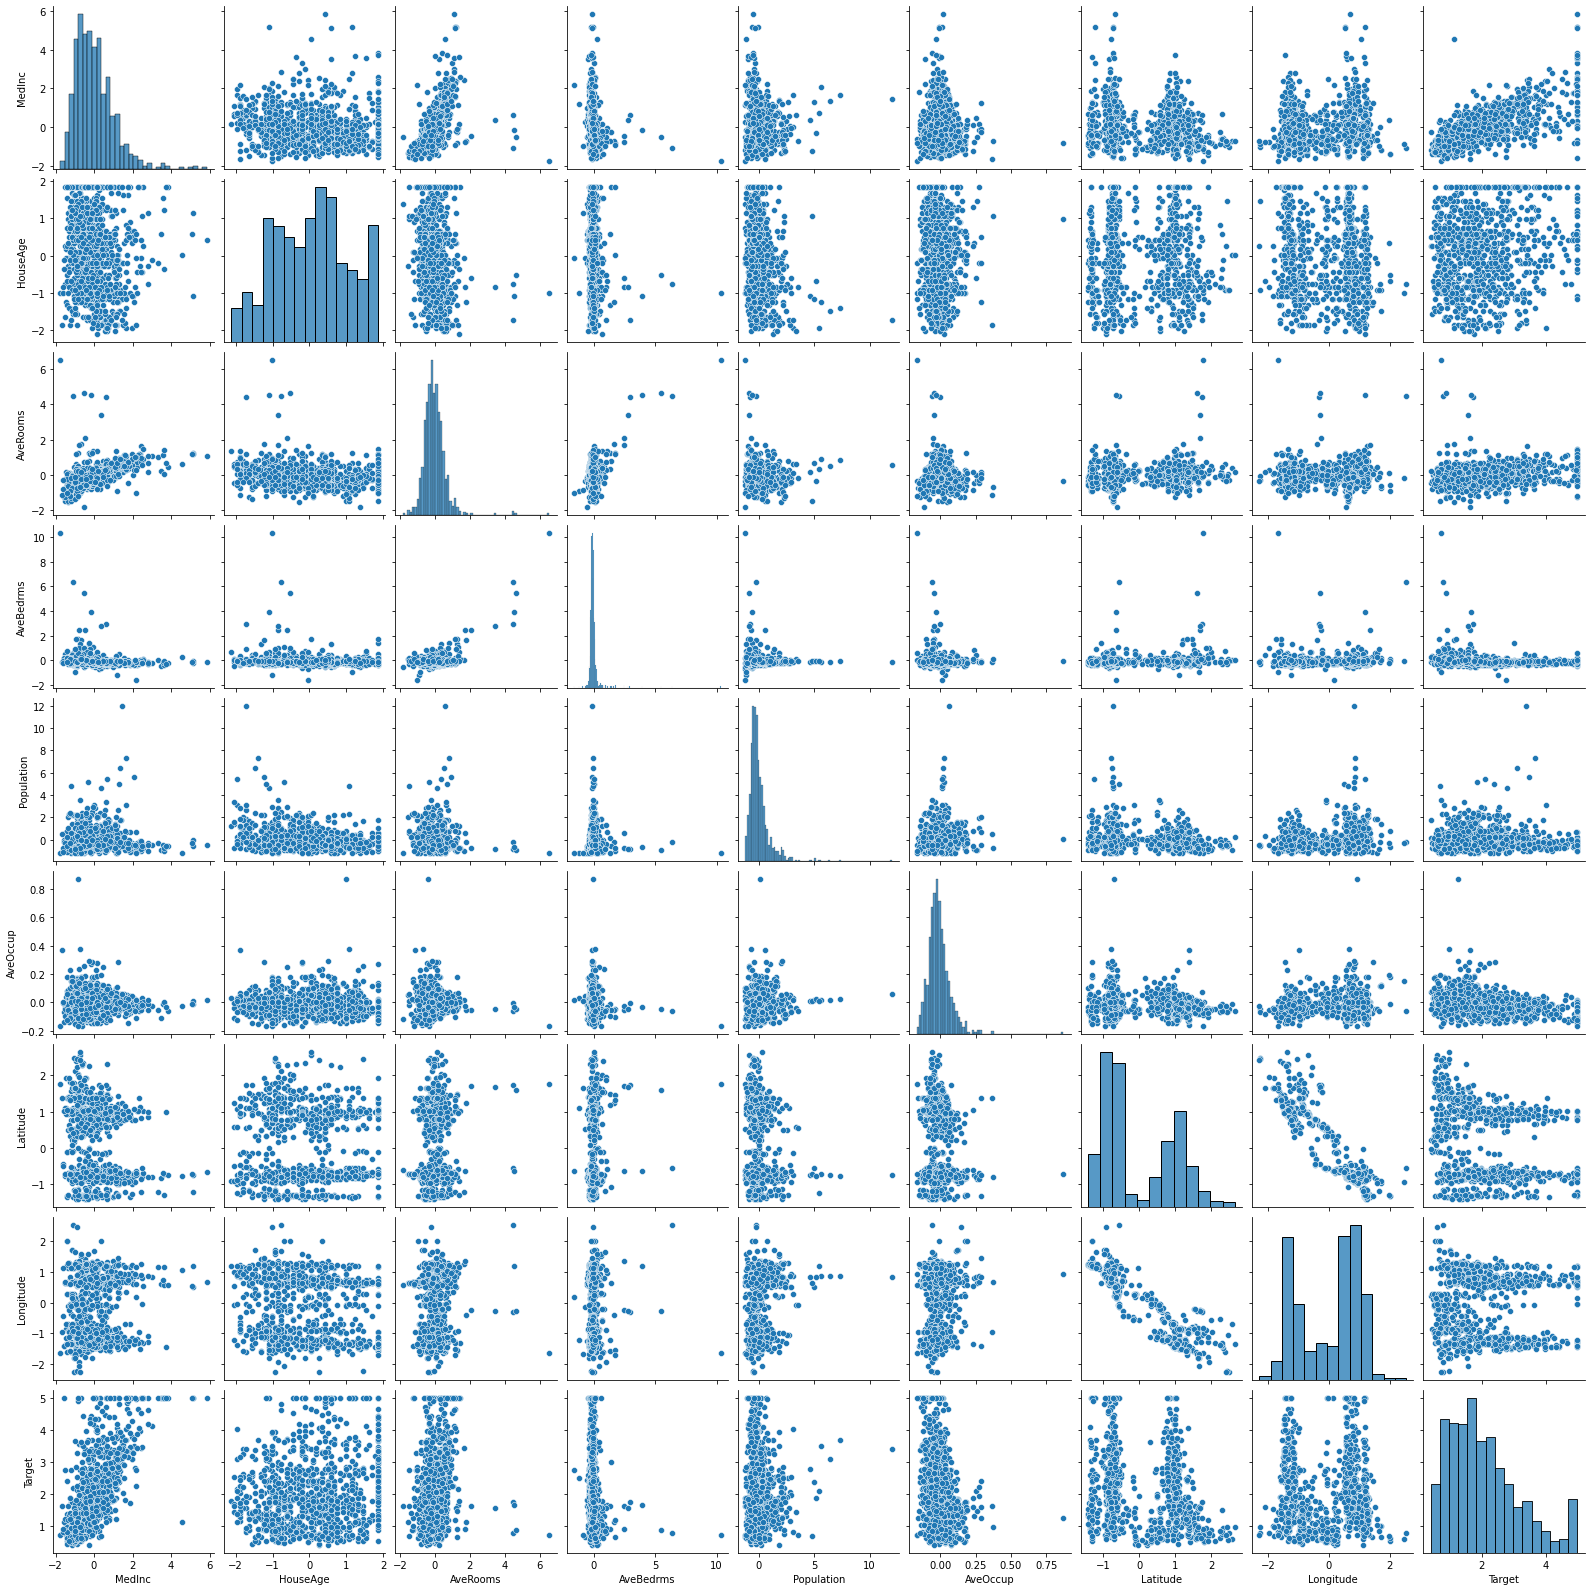

In [11]:
sns.pairplot(df.sample(1000))
plt.show()

## Train model with PyTorch

In [12]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

In [13]:
data = torch.from_numpy(df.values).float()
data.shape

torch.Size([20640, 9])

In [14]:
X = data[:,:-1]
y = data[:,-1:]

print(X.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [15]:
n_epochs = 4000
batch_size = 2^8
print_interval = 200
learning_rate = 1e-2

### Build Models 

In [23]:
model = nn.Sequential(
    nn.Linear(X.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)))

model

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)

In [24]:
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [27]:
# |X| = (total_size, input_dim)
# |y| = (total_size, output_dim)

for i in range(n_epochs) : 
    # Shuffle the index to feed-forward.
    indices = torch.randperm(X.size(0)) # shuffle
    X_ = torch.index_select(X, dim = 0, index = indices)
    y_ = torch.index_select(y, dim = 0, index = indices)
    
    X_ = X_.split(batch_size, dim = 0)
    y_ = y_.split(batch_size, dim = 0)
    
    # |X_[i]| = (batch_size, input_dim)
    # |y_[i]| = (batch_size, output_dim)
    
    y_hat = []
    total_loss = 0
    
    for X_i, y_i in zip(X_, y_) : 
        # |X_i| = |X_[i]|
        # |y_i| = |y_[i]|
        y_hat_i = model(X_i)
        loss = F.mse_loss(y_hat_i, y_i)
        
        optimizer.zero_grad() # initializing
        loss.backward() # backward
        
        optimizer.step() # update
        
        total_loss += float(loss) # tensor -> float (to prevent memory leak)
        y_hat += [y_hat_i]
        
    total_loss = total_loss/len(X_)
    if (i + 1) % print_interval == 0 : 
        print('Epoch %d : loss = %.4e' % (i + 1, total_loss))
    
y_hat = torch.cat(y_hat, dim = 0)
y = torch.cat(y_, dim = 0)
# |y_hat| = (total_size, output_dim)
# |y| = (total_size, output_dim)

Epoch 200 : loss = 3.1253e-01
Epoch 400 : loss = 3.0863e-01
Epoch 600 : loss = 3.0830e-01
Epoch 800 : loss = 3.0082e-01
Epoch 1000 : loss = 2.9626e-01
Epoch 1200 : loss = 2.9520e-01
Epoch 1400 : loss = 2.9471e-01
Epoch 1600 : loss = 2.9494e-01
Epoch 1800 : loss = 2.9380e-01
Epoch 2000 : loss = 2.9418e-01
Epoch 2200 : loss = 2.9394e-01
Epoch 2400 : loss = 2.9413e-01
Epoch 2600 : loss = 2.9464e-01
Epoch 2800 : loss = 2.9291e-01
Epoch 3000 : loss = 2.9295e-01
Epoch 3200 : loss = 2.9346e-01
Epoch 3400 : loss = 2.9236e-01
Epoch 3600 : loss = 2.9166e-01
Epoch 3800 : loss = 2.9173e-01
Epoch 4000 : loss = 2.9301e-01


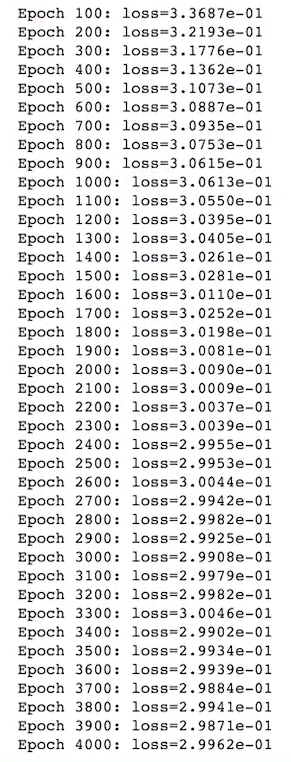

## Result

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


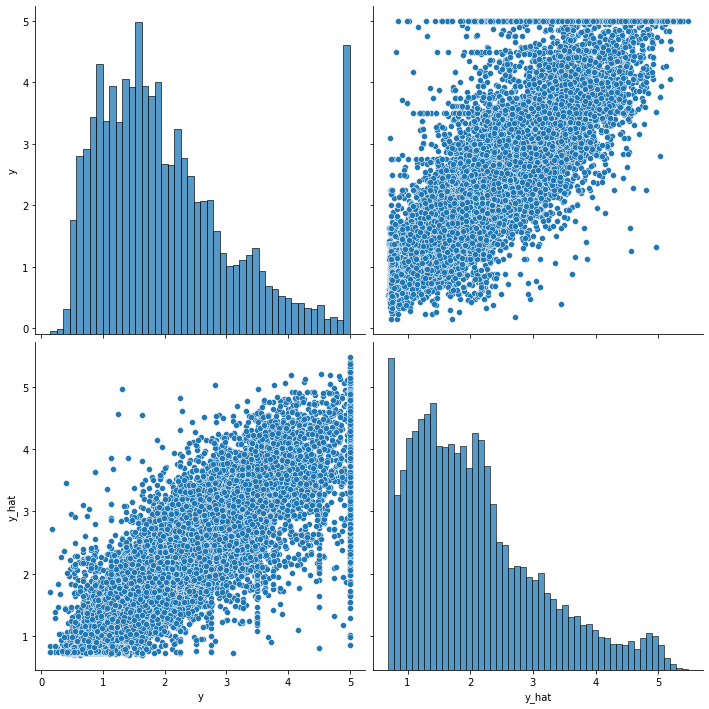

In [28]:
df = pd.DataFrame(torch.cat([y, y_hat], dim = 1).detach().numpy(),
                 columns = ['y', 'y_hat'])

sns.pairplot(df, size = 5)
plt.show()